In [1]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from urllib.request import urlopen

In [2]:
mapping_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
class_id_to_name = eval(urlopen(mapping_url).read())

In [3]:
model = torchvision.models.inception_v3(pretrained=True)
model.eval();

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
def predict(img):
    output = model(img)
    _, output_class = output.data.max(dim=1)
    return output_class.item()

In [6]:
def imshow(img):
    img -= img.min()
    img /= img.max()
    img = img.numpy()
    img.clip(0, 1, out=img)
    return np.transpose(img, (1,2,0))

In [7]:
def create_adv_image(path, fake_class, lambd=1, eps = 0.3):
    true_image = Image.open(path)
    true_image = transform(true_image)
    true_image.unsqueeze_(0);
    
    # Sanity check
    print('True Image class: ',predict(true_image), 'a.k.a.', class_id_to_name[predict(true_image)].split(',')[0])
    
    true_image_min = true_image - eps
    true_image_max = true_image + eps
    
    adv_image = true_image.clone().requires_grad_();
    adv_image = torch.autograd.Variable(adv_image, requires_grad=True)

    for i in range(100):
        out_adv = model(adv_image)
        _, out_idx = out_adv.data.max(dim=1)
        print('Epoch: ', i, 
              '; Fake Prob: ', F.softmax(out_adv.data[0], dim=0)[fake_class ].item(), 
              'Current Prediction: ', out_idx.item(), 
              'a.k.a.', class_id_to_name[out_idx.item()].split(',')[0])
        if out_idx.numpy() == fake_class:
            break
        out_adv[0,fake_class].backward()
        adv_image_grad = adv_image.grad.data
        adv_image.data += lambd*adv_image_grad/adv_image_grad.norm()
        adv_image.grad.data.zero_()

        adv_image = torch.autograd.Variable(adv_image, requires_grad=False)
        adv_image = torch.max(adv_image, true_image_min)
        adv_image = torch.min(adv_image, true_image_max)
        adv_image = torch.autograd.Variable(adv_image, requires_grad=True)
        
    return true_image, adv_image

In [8]:
def plot_attack(true, adv):
    true_img_pred = predict(true)
    adv_img_pred = predict(adv)
    noise = adv.detach().data[0]-true[0]
    noise_img_pred = predict(noise.unsqueeze(0))

    plt.figure(figsize=(15, 50))

    plt.subplot(1, 3, 1)
    plt.imshow(imshow(true_image[0]));
    plt.title('True Image; Prediction: ' + class_id_to_name[true_img_pred].split(',')[0]);

    plt.subplot(1, 3, 2)
    plt.imshow(imshow(noise));
    plt.title('Added Noise; Prediction: ' + class_id_to_name[noise_img_pred].split(',')[0]);

    plt.subplot(1, 3, 3)
    plt.imshow(imshow(adv_image.detach()[0]));
    plt.title('Adversarial Image; Prediction: ' + class_id_to_name[adv_img_pred].split(',')[0]);

In [9]:
def check_robustness(adv_img):
    adv_image.detach_().squeeze_(0);
    
    plt.figure(figsize=(15, 50))

    plt.subplot(1, 4, 1)
    flipped = torch.flip(adv_image,[2])
    plt.imshow(imshow(flipped));
    predicted_class = class_id_to_name[predict(flipped.unsqueeze(0))].split(',')[0]
    plt.title('Flipped; Prediction: ' + predicted_class, fontsize=10)
    
    plt.subplot(1, 4, 2)
    transform2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(180),
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    cropped80 = transform2(adv_image)
    plt.imshow(imshow(cropped80));
    predicted_class = class_id_to_name[predict(cropped80.unsqueeze(0))].split(',')[0]
    plt.title('Cropped; Prediction: ' + predicted_class, fontsize=10)
    
    plt.subplot(1, 4, 3)
    transform3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation([29.99,30.01]),
        transforms.ToTensor()
    ])
    rotated30 = transform3(adv_image)
    plt.imshow(imshow(rotated30))
    predicted_class = class_id_to_name[predict(rotated30.unsqueeze(0))].split(',')[0]
    plt.title('Rotated; Prediction: ' + predicted_class, fontsize=10)
    
    plt.subplot(1, 4, 4)
    gray = (0.299*adv_image[0] + 0.587*adv_image[1] + 0.114*adv_image[2]).unsqueeze_(0).expand(3,224,224)
    plt.imshow(imshow(gray))
    predicted_class = class_id_to_name[predict(gray.unsqueeze(0))].split(',')[0]
    plt.title('Grayscale; Prediction: ' + predicted_class, fontsize=10)

True Image class:  945 a.k.a. bell pepper
Epoch:  0 ; Fake Prob:  1.1781084996442814e-09 Current Prediction:  945 a.k.a. bell pepper
Epoch:  1 ; Fake Prob:  7.614775476838531e-09 Current Prediction:  945 a.k.a. bell pepper
Epoch:  2 ; Fake Prob:  3.404812431995197e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  3 ; Fake Prob:  7.052553741004886e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  4 ; Fake Prob:  6.662014584435383e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  5 ; Fake Prob:  9.978134585253429e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  6 ; Fake Prob:  4.5908308266007225e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  7 ; Fake Prob:  1.0791919891062207e-07 Current Prediction:  945 a.k.a. bell pepper
Epoch:  8 ; Fake Prob:  4.3099070978769305e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  9 ; Fake Prob:  8.653501737398983e-08 Current Prediction:  945 a.k.a. bell pepper
Epoch:  10 ; Fake Prob:  4.7173895012520006e-08 Curren

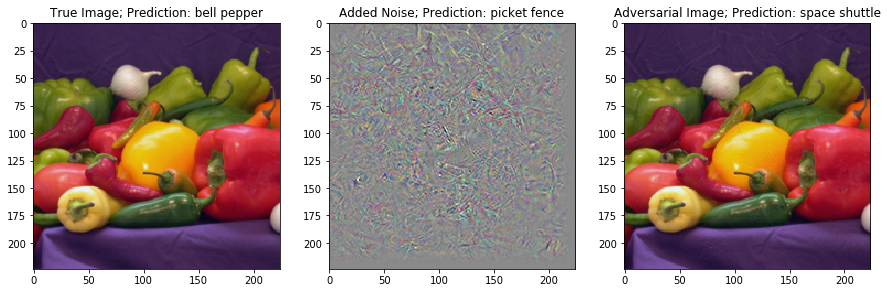

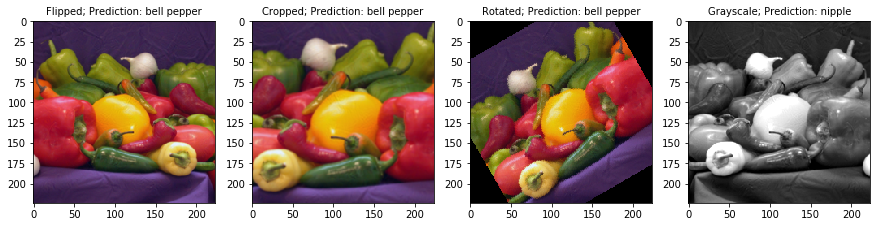

In [10]:
true_image, adv_image = create_adv_image(path='hw2/peppers.png', fake_class=812)
plot_attack(true_image, adv_image)
check_robustness(adv_image)

True Image class:  208 a.k.a. Labrador retriever
Epoch:  0 ; Fake Prob:  8.911795190691407e-10 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  1 ; Fake Prob:  3.0640074921706173e-09 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  2 ; Fake Prob:  1.1038431502186086e-08 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  3 ; Fake Prob:  3.008643645330267e-08 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  4 ; Fake Prob:  1.1730346471949815e-07 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  5 ; Fake Prob:  1.2114566061427468e-07 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  6 ; Fake Prob:  1.5751604109937034e-07 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  7 ; Fake Prob:  3.957121066378022e-07 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  8 ; Fake Prob:  4.671495332786435e-07 Current Prediction:  208 a.k.a. Labrador retriever
Epoch:  9 ; Fake Prob:  1.6597215335423243e-06 Current Prediction:  208 a

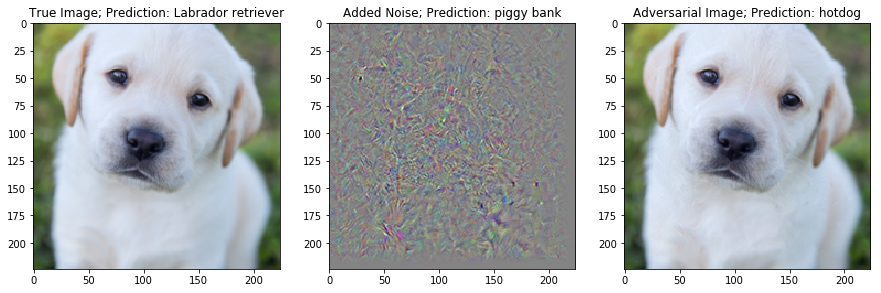

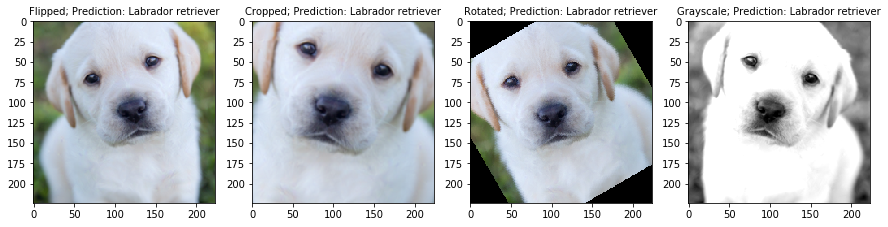

In [11]:
true_image, adv_image = create_adv_image(path='hw2/dog.jpg', fake_class=934)
plot_attack(true_image, adv_image)
check_robustness(adv_image)

True Image class:  291 a.k.a. lion
Epoch:  0 ; Fake Prob:  2.624408807605505e-06 Current Prediction:  291 a.k.a. lion
Epoch:  1 ; Fake Prob:  1.7450132872909307e-05 Current Prediction:  291 a.k.a. lion
Epoch:  2 ; Fake Prob:  0.00019190748571418226 Current Prediction:  291 a.k.a. lion
Epoch:  3 ; Fake Prob:  0.002790214028209448 Current Prediction:  291 a.k.a. lion
Epoch:  4 ; Fake Prob:  0.03726306930184364 Current Prediction:  291 a.k.a. lion
Epoch:  5 ; Fake Prob:  0.23262768983840942 Current Prediction:  291 a.k.a. lion
Epoch:  6 ; Fake Prob:  0.6799654364585876 Current Prediction:  292 a.k.a. tiger


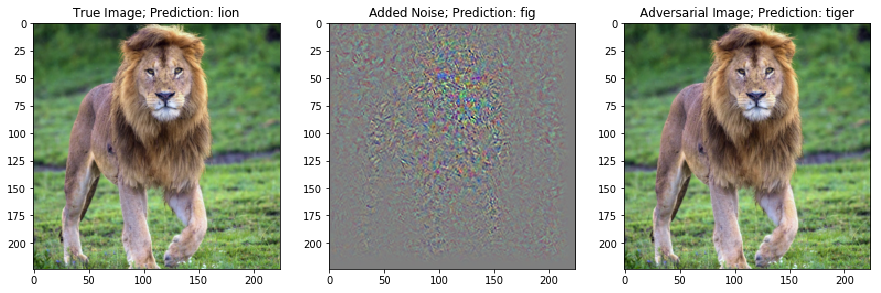

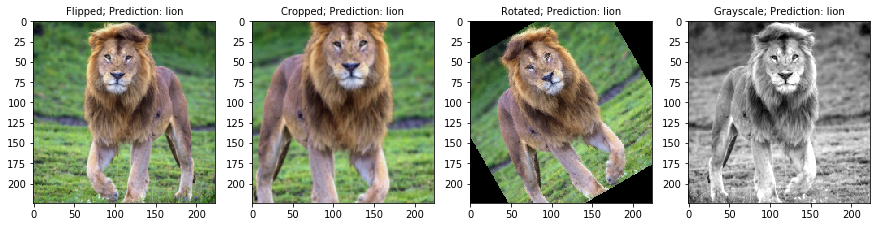

In [12]:
true_image, adv_image = create_adv_image(path='hw2/lion.jpg', fake_class=292)
plot_attack(true_image, adv_image)
check_robustness(adv_image)

True Image class:  281 a.k.a. tabby
Epoch:  0 ; Fake Prob:  1.524420700782514e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  1 ; Fake Prob:  1.4541171600157554e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  2 ; Fake Prob:  1.7382270067756167e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  3 ; Fake Prob:  2.3020754191804826e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  4 ; Fake Prob:  2.8554023590032784e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  5 ; Fake Prob:  3.242873081177322e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  6 ; Fake Prob:  3.839075279898907e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  7 ; Fake Prob:  4.928540686677252e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  8 ; Fake Prob:  3.5055469638223258e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  9 ; Fake Prob:  8.355577563179395e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  10 ; Fake Prob:  4.241645257252458e-09 Current Prediction:  281 a.k.a. tabby
Epoch:  11 ; Fake Prob:  1.9238671

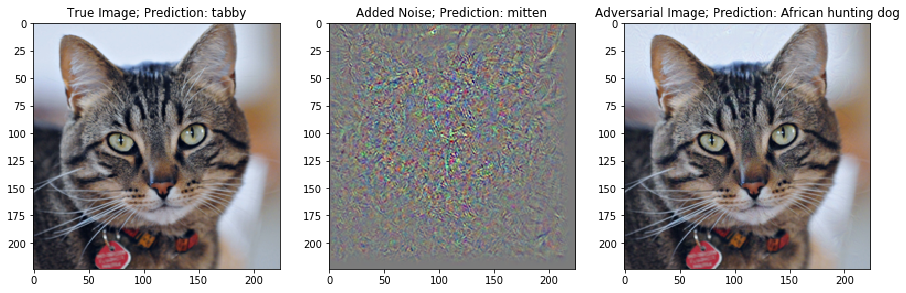

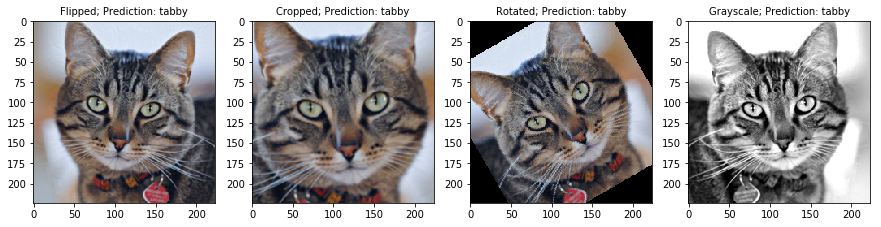

In [13]:
true_image, adv_image = create_adv_image(path='hw2/cat.jpg', fake_class=275)
plot_attack(true_image, adv_image)
check_robustness(adv_image)